# DEEPOO-1 MODEL TRAINING - 224x224 IMG_SIZE

In [1]:
import os
import random
from pathlib import Path
import tensorflow as tf
from tensorflow import keras

## CONFIGURATION

In [28]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 4  # Adjust as needed
EPOCHS = 100
NUM_CLASSES = 1  # Change if you have more than one object class

DATA_DIR = Path('/content/normalized-224x224')
TRAIN_IMG_DIR = DATA_DIR / 'train' / 'images'
TRAIN_MASK_DIR = DATA_DIR / 'train' / 'masks'
VAL_IMG_DIR = DATA_DIR / 'val' / 'images'
VAL_MASK_DIR = DATA_DIR / 'val' / 'masks'
TEST_IMG_DIR = DATA_DIR / 'test' / 'images'
TEST_MASK_DIR = DATA_DIR / 'test' / 'masks'
MODEL_DIR = Path('/content/models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

## DATA LOADING

In [3]:
def list_image_mask_pairs(img_dir, mask_dir):
    img_files = sorted([f for f in img_dir.iterdir() if f.suffix in ['.png', '.jpg', '.jpeg']])
    pairs = []
    for img_path in img_files:
        mask_path = mask_dir / (img_path.stem + '.png')
        if mask_path.exists():
            pairs.append((str(img_path), str(mask_path)))
    return pairs

train_pairs = list_image_mask_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_pairs = list_image_mask_pairs(VAL_IMG_DIR, VAL_MASK_DIR)
test_pairs = list_image_mask_pairs(TEST_IMG_DIR, TEST_MASK_DIR)


# DATASET PIPELINE

In [16]:
def load_image_mask(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask > 127, tf.float32)  # Binary mask: 0 or 1
    return img, mask

def augment_image_mask(img, mask):
    # Random flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    # Random up/down flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    # Random rotation (0, 90, 180, 270 degrees)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)
    # Random brightness/contrast (image only)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    return img, mask

def scale_image_mask(img, mask):
    img = tf.image.resize(img, IMG_SIZE)
    mask = tf.image.resize(mask, IMG_SIZE)
    return img, mask

def make_dataset(pairs, shuffle=True, augment=False):
    img_paths, mask_paths = zip(*pairs)
    ds = tf.data.Dataset.from_tensor_slices((list(img_paths), list(mask_paths)))
    ds = ds.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(scale_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

In [17]:
train_ds = make_dataset(train_pairs, shuffle=True, augment=True)
val_ds = make_dataset(val_pairs, shuffle=False, augment=False)
test_ds = make_dataset(test_pairs, shuffle=False, augment=False)

## MODEL DEFINITION: DeepLabV3+ with MobileNetV2 backbone

In [29]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Helper: Simple DeepLabV3+ head for binary segmentation
# Note: For production, consider using keras_cv or TF Model Garden for more advanced heads

def DeepLabV3Plus(input_shape=(IMG_SIZE + (3,)), num_classes=1):
    # Encoder: MobileNetV2 backbone (pretrained on ImageNet)
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze backbone for feature extraction
    # To fine-tune later, set base_model.trainable = True and recompile the model
    # Extract low-level and high-level features
    layer_names = [
        'block_1_expand_relu',   # low-level features
        'out_relu',              # high-level features
    ]
    low_level_feat = base_model.get_layer(layer_names[0]).output
    x = base_model.get_layer(layer_names[1]).output

    # ASPP (atrous spatial pyramid pooling)
    b0 = layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    b0 = layers.BatchNormalization()(b0)
    b0 = layers.Activation('relu')(b0)

    # Upsample ASPP output to match low-level feature map shape
    # Use dynamic resizing for compatibility with any input size
    def resize_to(tensor, target):
        target_shape = tf.shape(target)[1:3]
        return tf.image.resize(tensor, target_shape, method='bilinear')

    x = layers.Lambda(lambda tensors: resize_to(tensors[0], tensors[1]))([b0, low_level_feat])
    low_level_feat = layers.Conv2D(48, 1, padding='same', use_bias=False)(low_level_feat)
    low_level_feat = layers.BatchNormalization()(low_level_feat)
    low_level_feat = layers.Activation('relu')(low_level_feat)
    x = layers.Concatenate()([x, low_level_feat])

    # Decoder
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # Upsample to original input size
    x = layers.Lambda(lambda t: tf.image.resize(t, IMG_SIZE, method='bilinear'))(x)

    # Output: 1 channel, sigmoid for binary segmentation
    outputs = layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

model = DeepLabV3Plus(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,884,033 (14.82 MB)

 Trainable params: 1,624,417 (6.20 MB)

 Non-trainable params: 2,259,616 (8.62 MB)

## TRAINING SETUP

### METRICS

In [30]:
def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return tf.math.divide_no_nan(intersection, union)

def dice_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    summation = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return tf.math.divide_no_nan(2. * intersection, summation)

## STAGE 1: TRAIN DECODER/HEAD WITH FROZEN BACKBONE

In [31]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', iou_metric, dice_metric]
)

In [32]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=str(MODEL_DIR / 'deepoo-1-224x224-best_model.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

### TRAINING LOOP

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb]
)

Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9179 - dice_metric: 0.1774 - iou_metric: 0.1102 - loss: 0.2303

401/401 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.9181 - dice_metric: 0.1775 - iou_metric: 0.1103 - loss: 0.2300 - val_accuracy: 0.9713 - val_dice_metric: 0.3323 - val_iou_metric: 0.2268 - val_loss: 0.0850
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9640 - dice_metric: 0.3626 - iou_metric: 0.2393 - loss: 0.1064

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9641 - dice_metric: 0.3626 - iou_metric: 0.2393 - loss: 0.1064 - val_accuracy: 0.9725 - val_dice_metric: 0.3692 - val_iou_metric: 0.2522 - val_loss: 0.0762
Epoch 3/100
399/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9666 - dice_metric: 0.4251 - iou_metric: 0.2887 - loss: 0.0944

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9667 - dice_metric: 0.4250 - iou_metric: 0.2886 - loss: 0.0942 - val_accuracy: 0.9759 - val_dice_metric: 0.3916 - val_iou_metric: 0.2727 - val_loss: 0.0702
Epoch 4/100
400/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9686 - dice_metric: 0.4863 - iou_metric: 0.3403 - loss: 0.0886

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9687 - dice_metric: 0.4862 - iou_metric: 0.3402 - loss: 0.0884 - val_accuracy: 0.9780 - val_dice_metric: 0.3215 - val_iou_metric: 0.2270 - val_loss: 0.0678
Epoch 5/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9694 - dice_metric: 0.5063 - iou_metric: 0.3571 - loss: 0.0856

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9695 - dice_metric: 0.5062 - iou_metric: 0.3571 - loss: 0.0856 - val_accuracy: 0.9781 - val_dice_metric: 0.3023 - val_iou_metric: 0.2116 - val_loss: 0.0665
Epoch 6/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9716 - dice_metric: 0.5385 - iou_metric: 0.3888 - loss: 0.0786

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9716 - dice_metric: 0.5384 - iou_metric: 0.3887 - loss: 0.0786 - val_accuracy: 0.9786 - val_dice_metric: 0.4012 - val_iou_metric: 0.2883 - val_loss: 0.0613
Epoch 7/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9720 - dice_metric: 0.5554 - iou_metric: 0.4045 - loss: 0.0764

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9721 - dice_metric: 0.5553 - iou_metric: 0.4045 - loss: 0.0763 - val_accuracy: 0.9789 - val_dice_metric: 0.4440 - val_iou_metric: 0.3216 - val_loss: 0.0604
Epoch 8/100
399/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9726 - dice_metric: 0.5593 - iou_metric: 0.4090 - loss: 0.0740

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9727 - dice_metric: 0.5591 - iou_metric: 0.4088 - loss: 0.0738 - val_accuracy: 0.9797 - val_dice_metric: 0.3825 - val_iou_metric: 0.2793 - val_loss: 0.0573
Epoch 9/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9739 - dice_metric: 0.5835 - iou_metric: 0.4319 - loss: 0.0697 - val_accuracy: 0.9793 - val_dice_metric: 0.4610 - val_iou_metric: 0.3384 - val_loss: 0.0583
Epoch 10/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9742 - dice_metric: 0.6119 - iou_metric: 0.4589 - loss: 0.0694 - val_accuracy: 0.9794 - val_dice_metric: 0.3973 - val_iou_metric: 0.2895 - val_loss: 0.0607
Epoch 11/100
400/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9751 - dice_metric: 0.6019 - iou_metric: 0.4509 - loss: 0.0661

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9751 - dice_metric: 0.6017 - iou_metric: 0.4507 - loss: 0.0660 - val_accuracy: 0.9805 - val_dice_metric: 0.4356 - val_iou_metric: 0.3198 - val_loss: 0.0569
Epoch 12/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9747 - dice_metric: 0.6120 - iou_metric: 0.4600 - loss: 0.0672

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9747 - dice_metric: 0.6119 - iou_metric: 0.4600 - loss: 0.0672 - val_accuracy: 0.9803 - val_dice_metric: 0.4756 - val_iou_metric: 0.3525 - val_loss: 0.0561
Epoch 13/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9759 - dice_metric: 0.6204 - iou_metric: 0.4668 - loss: 0.0646 - val_accuracy: 0.9767 - val_dice_metric: 0.4904 - val_iou_metric: 0.3578 - val_loss: 0.0637
Epoch 14/100
399/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9753 - dice_metric: 0.6387 - iou_metric: 0.4852 - loss: 0.0660

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9754 - dice_metric: 0.6385 - iou_metric: 0.4852 - loss: 0.0658 - val_accuracy: 0.9807 - val_dice_metric: 0.4674 - val_iou_metric: 0.3461 - val_loss: 0.0542
Epoch 15/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9762 - dice_metric: 0.6395 - iou_metric: 0.4877 - loss: 0.0629 - val_accuracy: 0.9804 - val_dice_metric: 0.4222 - val_iou_metric: 0.3143 - val_loss: 0.0565
Epoch 16/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9758 - dice_metric: 0.6391 - iou_metric: 0.4885 - loss: 0.0631 - val_accuracy: 0.9813 - val_dice_metric: 0.4547 - val_iou_metric: 0.3378 - val_loss: 0.0561
Epoch 17/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9778 - dice_metric: 0.6608 - iou_metric: 0.5104 - loss: 0.0577 - val_accuracy: 0.9799 - val_dice_metric: 0.5114 - val_iou_metric: 0.3817 - val_loss: 0.0564
Epoch 18/100
399/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9777 - dice_metric: 0.6614 - iou_metric:

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9777 - dice_metric: 0.6612 - iou_metric: 0.5124 - loss: 0.0585 - val_accuracy: 0.9817 - val_dice_metric: 0.4967 - val_iou_metric: 0.3726 - val_loss: 0.0541
Epoch 19/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9777 - dice_metric: 0.6718 - iou_metric: 0.5217 - loss: 0.0574 - val_accuracy: 0.9814 - val_dice_metric: 0.4526 - val_iou_metric: 0.3366 - val_loss: 0.0566
Epoch 20/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9781 - dice_metric: 0.6737 - iou_metric: 0.5257 - loss: 0.0566

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9781 - dice_metric: 0.6736 - iou_metric: 0.5256 - loss: 0.0565 - val_accuracy: 0.9819 - val_dice_metric: 0.4630 - val_iou_metric: 0.3464 - val_loss: 0.0528
Epoch 21/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9760 - dice_metric: 0.6595 - iou_metric: 0.5094 - loss: 0.0631 - val_accuracy: 0.9809 - val_dice_metric: 0.4328 - val_iou_metric: 0.3224 - val_loss: 0.0555
Epoch 22/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9776 - dice_metric: 0.6793 - iou_metric: 0.5294 - loss: 0.0575 - val_accuracy: 0.9812 - val_dice_metric: 0.4413 - val_iou_metric: 0.3278 - val_loss: 0.0549
Epoch 23/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9788 - dice_metric: 0.6788 - iou_metric: 0.5344 - loss: 0.0545 - val_accuracy: 0.9815 - val_dice_metric: 0.4756 - val_iou_metric: 0.3569 - val_loss: 0.0531
Epoch 24/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9792 - dice_metric: 0.6948 - iou_metric

401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9807 - dice_metric: 0.7106 - iou_metric: 0.5666 - loss: 0.0482 - val_accuracy: 0.9830 - val_dice_metric: 0.5534 - val_iou_metric: 0.4212 - val_loss: 0.0505
Epoch 30/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9806 - dice_metric: 0.7195 - iou_metric: 0.5751 - loss: 0.0492 - val_accuracy: 0.9818 - val_dice_metric: 0.4524 - val_iou_metric: 0.3395 - val_loss: 0.0551
Epoch 31/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9805 - dice_metric: 0.7184 - iou_metric: 0.5737 - loss: 0.0493 - val_accuracy: 0.9831 - val_dice_metric: 0.5102 - val_iou_metric: 0.3900 - val_loss: 0.0514
Epoch 32/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.9801 - dice_metric: 0.7259 - iou_metric: 0.5829 - loss: 0.0502 - val_accuracy: 0.9817 - val_dice_metric: 0.5046 - val_iou_metric: 0.3839 - val_loss: 0.0541
Epoch 33/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9796 - dice_metric: 0.7141 - iou_metric

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

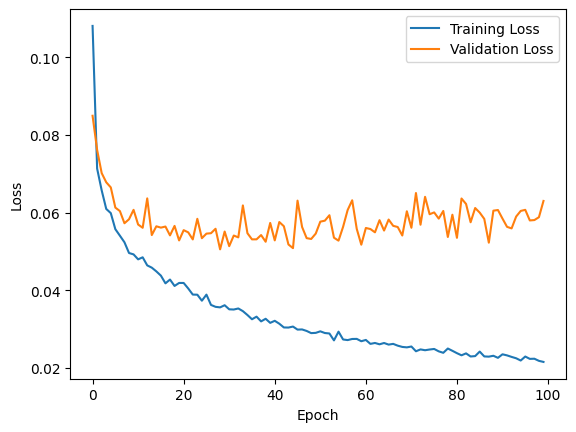

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

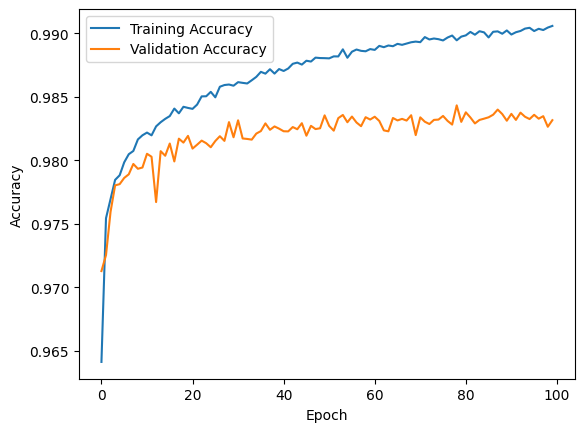

In [36]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

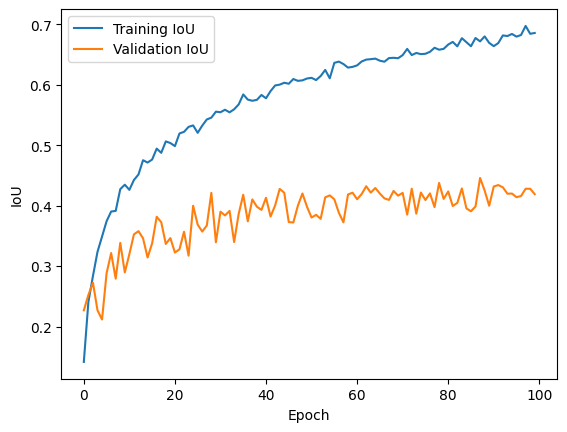

In [37]:
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

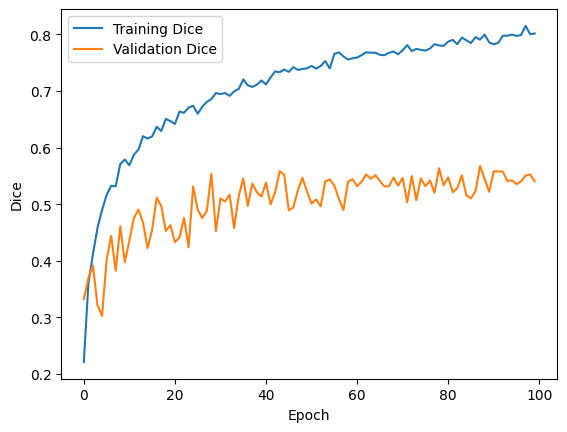

In [38]:
plt.plot(history.history['dice_metric'], label='Training Dice')
plt.plot(history.history['val_dice_metric'], label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

In [39]:
model.load_weights(str(MODEL_DIR / 'deepoo-1-224x224-best_model.h5'))

In [40]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', iou_metric, dice_metric]
)

In [41]:
model.evaluate(test_ds, verbose=2)

111/111 - 9s - 85ms/step - accuracy: 0.9820 - dice_metric: 0.5491 - iou_metric: 0.4191 - loss: 0.0527


[0.052718035876750946,
 0.9820000529289246,
 0.419077068567276,
 0.5490671396255493]

In [42]:
example = next(iter(val_ds))

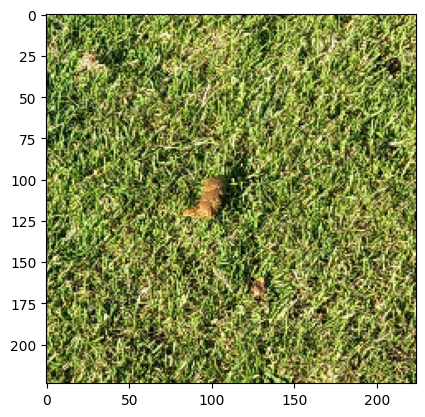

In [43]:
plt.imshow(example[0][1])

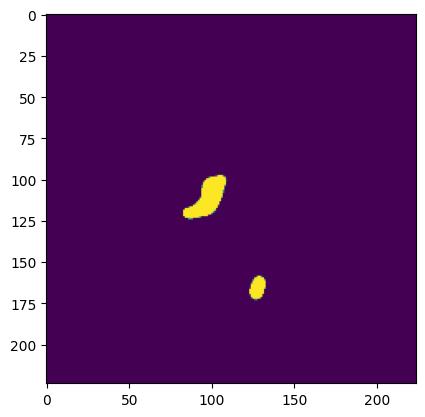

In [44]:
plt.imshow(example[1][1])

In [45]:
predictions = model.predict(example[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


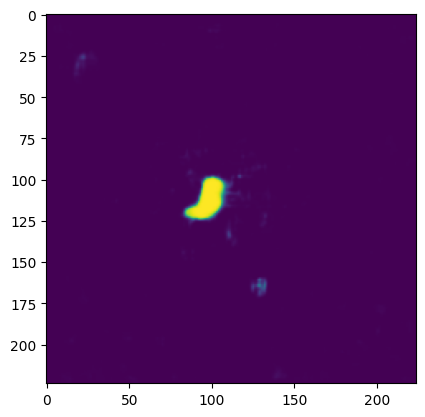

In [46]:
plt.imshow(predictions[1])

## STAGE 2: FINE-TUNE WITH BACKBONE UNFROZEN

In [47]:
# Unfreeze the backbone for fine-tuning
for layer in model.layers:
    if layer.name.startswith('block_') or layer.name.startswith('Conv1') or 'mobilenet' in layer.name:
        layer.trainable = True

# Re-compile with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', iou_metric, dice_metric]
)

In [48]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,884,033 (14.82 MB)

 Trainable params: 3,435,169 (13.10 MB)

 Non-trainable params: 448,864 (1.71 MB)

In [49]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=max(10, EPOCHS // 3),  # e.g., 10 or 1/3 of original epochs
    callbacks=[checkpoint_cb]
)

Epoch 1/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 93s 113ms/step - accuracy: 0.9661 - dice_metric: 0.4895 - iou_metric: 0.3428 - loss: 0.1151 - val_accuracy: 0.9791 - val_dice_metric: 0.3423 - val_iou_metric: 0.2510 - val_loss: 0.0938
Epoch 2/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9737 - dice_metric: 0.5808 - iou_metric: 0.4298 - loss: 0.0738 - val_accuracy: 0.9787 - val_dice_metric: 0.4199 - val_iou_metric: 0.3108 - val_loss: 0.0801
Epoch 3/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9738 - dice_metric: 0.6109 - iou_metric: 0.4593 - loss: 0.0695 - val_accuracy: 0.9781 - val_dice_metric: 0.4740 - val_iou_metric: 0.3611 - val_loss: 0.0734
Epoch 4/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9762 - dice_metric: 0.6519 - iou_metric: 0.5037 - loss: 0.0654 - val_accuracy: 0.9791 - val_dice_metric: 0.5041 - val_iou_metric: 0.3857 - val_loss: 0.0629
Epoch 5/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9759 - dice_metric: 0.6614 - iou_me

401/401 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9822 - dice_metric: 0.7413 - iou_metric: 0.6060 - loss: 0.0432 - val_accuracy: 0.9827 - val_dice_metric: 0.5894 - val_iou_metric: 0.4645 - val_loss: 0.0482
Epoch 15/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9823 - dice_metric: 0.7550 - iou_metric: 0.6191 - loss: 0.0423 - val_accuracy: 0.9825 - val_dice_metric: 0.5877 - val_iou_metric: 0.4631 - val_loss: 0.0490
Epoch 16/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9830 - dice_metric: 0.7591 - iou_metric: 0.6254 - loss: 0.0414 - val_accuracy: 0.9811 - val_dice_metric: 0.5844 - val_iou_metric: 0.4617 - val_loss: 0.0529
Epoch 17/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9830 - dice_metric: 0.7625 - iou_metric: 0.6296 - loss: 0.0406

401/401 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.9830 - dice_metric: 0.7625 - iou_metric: 0.6295 - loss: 0.0406 - val_accuracy: 0.9836 - val_dice_metric: 0.5904 - val_iou_metric: 0.4672 - val_loss: 0.0445
Epoch 18/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9831 - dice_metric: 0.7649 - iou_metric: 0.6318 - loss: 0.0400 - val_accuracy: 0.9841 - val_dice_metric: 0.5771 - val_iou_metric: 0.4552 - val_loss: 0.0486
Epoch 19/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9841 - dice_metric: 0.7680 - iou_metric: 0.6367 - loss: 0.0375 - val_accuracy: 0.9839 - val_dice_metric: 0.5912 - val_iou_metric: 0.4670 - val_loss: 0.0492
Epoch 20/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9836 - dice_metric: 0.7733 - iou_metric: 0.6414 - loss: 0.0385 - val_accuracy: 0.9843 - val_dice_metric: 0.5977 - val_iou_metric: 0.4730 - val_loss: 0.0520
Epoch 21/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9839 - dice_metric: 0.7659 - iou_metric: 0.

401/401 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.9849 - dice_metric: 0.7909 - iou_metric: 0.6648 - loss: 0.0348 - val_accuracy: 0.9849 - val_dice_metric: 0.6175 - val_iou_metric: 0.4915 - val_loss: 0.0425
Epoch 24/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9849 - dice_metric: 0.7926 - iou_metric: 0.6667 - loss: 0.0353 - val_accuracy: 0.9857 - val_dice_metric: 0.6067 - val_iou_metric: 0.4853 - val_loss: 0.0464
Epoch 25/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9847 - dice_metric: 0.7915 - iou_metric: 0.6648 - loss: 0.0358 - val_accuracy: 0.9850 - val_dice_metric: 0.6084 - val_iou_metric: 0.4847 - val_loss: 0.0456
Epoch 26/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9848 - dice_metric: 0.7859 - iou_metric: 0.6604 - loss: 0.0350 - val_accuracy: 0.9848 - val_dice_metric: 0.6060 - val_iou_metric: 0.4832 - val_loss: 0.0523
Epoch 27/33
401/401 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9851 - dice_metric: 0.7918 - iou_metric: 0.

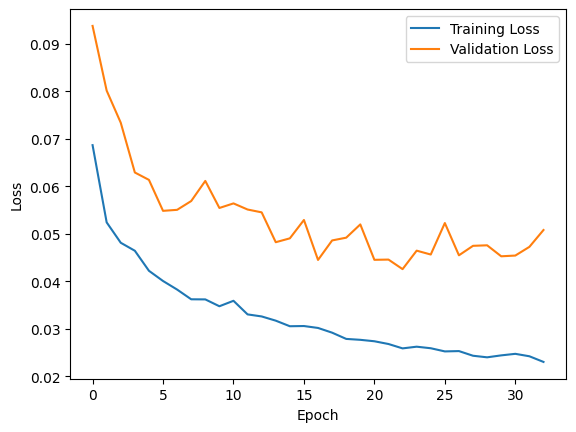

In [50]:
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

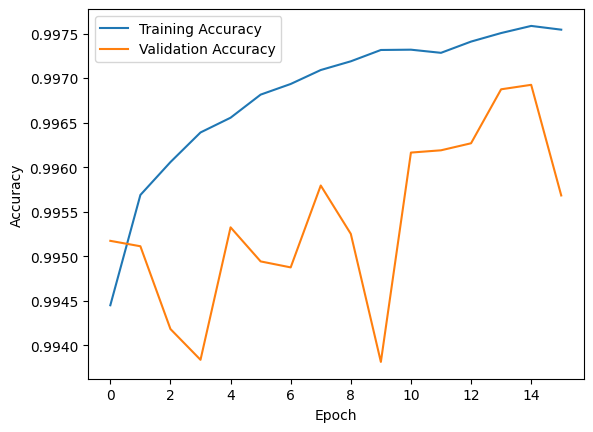

In [ ]:
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

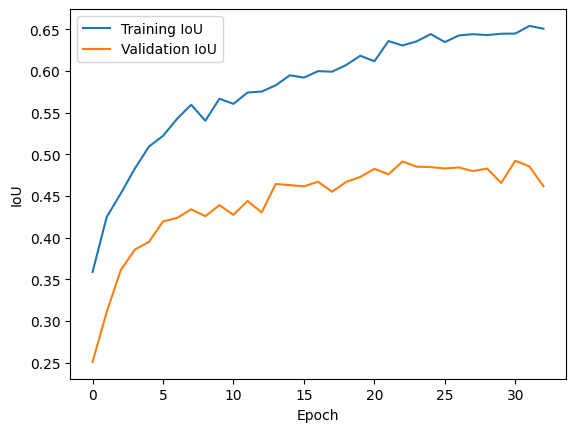

In [51]:
plt.plot(history_finetune.history['iou_metric'], label='Training IoU')
plt.plot(history_finetune.history['val_iou_metric'], label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

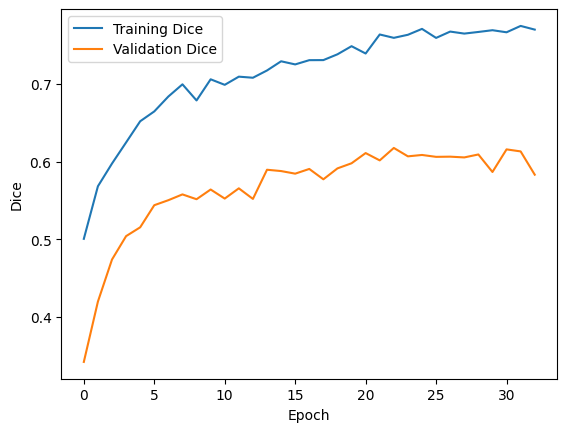

In [52]:
plt.plot(history_finetune.history['dice_metric'], label='Training Dice')
plt.plot(history_finetune.history['val_dice_metric'], label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

In [53]:
model.evaluate(test_ds, verbose=2)

111/111 - 4s - 37ms/step - accuracy: 0.9866 - dice_metric: 0.6245 - iou_metric: 0.5012 - loss: 0.0387


[0.038728971034288406,
 0.9865886569023132,
 0.5012496113777161,
 0.6245431900024414]

In [54]:
example = next(iter(val_ds))

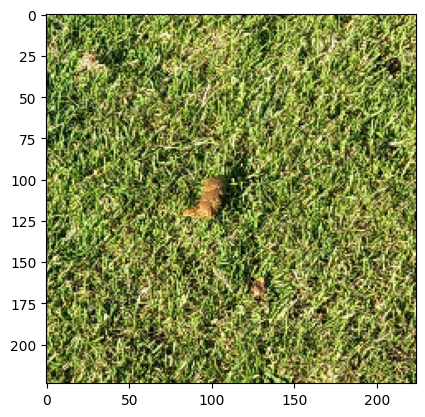

In [55]:
plt.imshow(example[0][1])

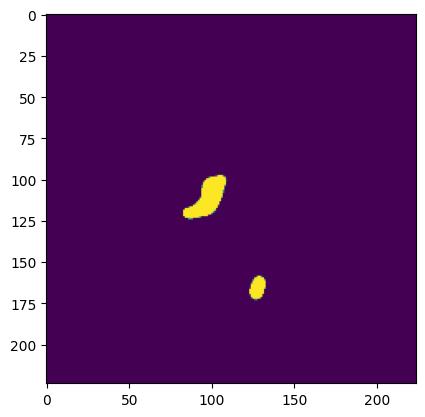

In [56]:
plt.imshow(example[1][1])

In [57]:
predictions = model.predict(example[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


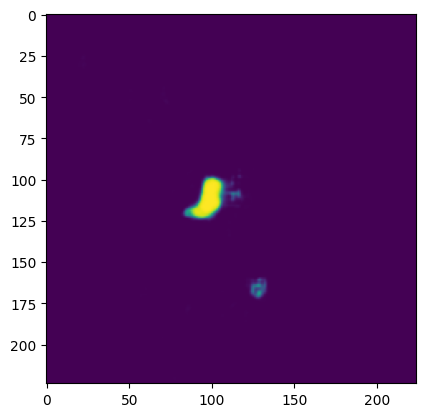

In [58]:
plt.imshow(predictions[1])